### Step 1: Dataset Selection

**Dataset Overview:** Oxford 102 Flower is an image classification dataset consisting of 102 flower categories. The flowers were chosen to be flowers commonly occurring in the United Kingdom. Each class consists of between 40 and 258 images.

The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category, and several very similar categories.

**class** torchvision.datasets.Flowers102(root: Union[str, Path], split: str = 'train', transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False)

**Parameters:**


*   **root** (str or pathlib.Path) – Root directory of the dataset.
*   **split** (string, optional) – The dataset split, supports "train" (default), "val", or "test".
*   **transform** (callable, optional) – A function/transform that takes in a PIL image and returns a transformed version. E.g, transforms.RandomCrop.
*   **target_transform** (callable, optional) – A function/transform that takes in the target and transforms it.
*   **download** (bool, optional) – If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.

In [ ]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
import scipy.io
import tarfile
from torchvision import datasets, transforms
import random
import glob
import shutil
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
import torch
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import itertools

In [ ]:
# File paths
mat_file_path = 'imagelabels.mat'
tar_file_path = '102flowers.tgz'
extracted_folder_path = '102flowers'

# Extract the tar file
if not os.path.exists(extracted_folder_path):
    os.makedirs(extracted_folder_path, exist_ok=True)
    with tarfile.open(tar_file_path, 'r:gz') as tar:
        tar.extractall(path=extracted_folder_path)

# Load the .mat file
mat_data = scipy.io.loadmat(mat_file_path)

# Extract labels
labels = mat_data['labels'][0]  # Flatten the labels array

# Count images per class
class_counts = Counter(labels)


In [ ]:
# Filter the top 10 classes with the highest number of images
top_10_classes = pd.DataFrame({
    "Class Index": list(class_counts.keys()),
    "Number of Images": list(class_counts.values())
}).nlargest(10, 'Number of Images')

# Get top 10 class indices
top_10_class_indices = top_10_classes['Class Index'].tolist()

# Define the class names for the top 10 classes
class_names_map = {
    51: "Petunia",
    77: "Passionflower",
    46: "Wallflower",
    73: "Water Lily",
    89: "Nasturtium",
    74: "Rose",
    81: "Plumeria",
    94: "Foxglove",
    88: "Cyclamen",
    78: "Lotus"
}

# Relabel the top 10 classes
relabel_map = {old_label: class_names_map[old_label] for old_label in top_10_class_indices}

# Prepare a new label array for top 10 classes with flower names
filtered_labels_with_names = [relabel_map[label] for label in labels if label in relabel_map]

# Check the result
top_10_classes, relabel_map


(    Class Index  Number of Images
 7            51               258
 0            77               251
 5            46               196
 1            73               194
 3            89               184
 6            74               171
 4            81               166
 93           94               162
 2            88               154
 11           78               137,
 {51: 'Petunia',
  77: 'Passionflower',
  46: 'Wallflower',
  73: 'Water Lily',
  89: 'Nasturtium',
  74: 'Rose',
  81: 'Plumeria',
  94: 'Foxglove',
  88: 'Cyclamen',
  78: 'Lotus'})

In [ ]:
# Paths to extracted images
image_folder_path = os.path.join(extracted_folder_path, 'jpg')
filtered_image_folder_path = 'top_10_classes_dataset'

# Create the new dataset directory for filtered images
if not os.path.exists(filtered_image_folder_path):
    os.makedirs(filtered_image_folder_path)

# Process and align images with the new labels
filtered_images = []
image_files = sorted(glob.glob(os.path.join(image_folder_path, '*.jpg')))  # Ensure order matches labels

for i, label in enumerate(labels):
    if label in relabel_map:  # Only consider images from the top 10 classes
        new_label = relabel_map[label]
        source_image_path = image_files[i]
        target_folder = os.path.join(filtered_image_folder_path, str(new_label))
        os.makedirs(target_folder, exist_ok=True)
        target_image_path = os.path.join(target_folder, os.path.basename(source_image_path))
        shutil.copy(source_image_path, target_image_path)  # Copy image to the new folder
        filtered_images.append((source_image_path, target_image_path, new_label))

# Summarize the number of images in the filtered dataset
filtered_class_counts = Counter([item[2] for item in filtered_images])
filtered_class_counts


Counter({'Passionflower': 251,
         'Water Lily': 194,
         'Cyclamen': 154,
         'Nasturtium': 184,
         'Plumeria': 166,
         'Wallflower': 196,
         'Rose': 171,
         'Petunia': 258,
         'Lotus': 137,
         'Foxglove': 162})

Displaying images for Class: Petunia


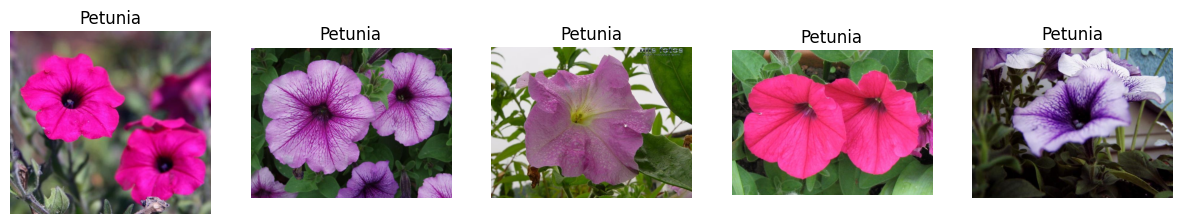

Displaying images for Class: Passionflower


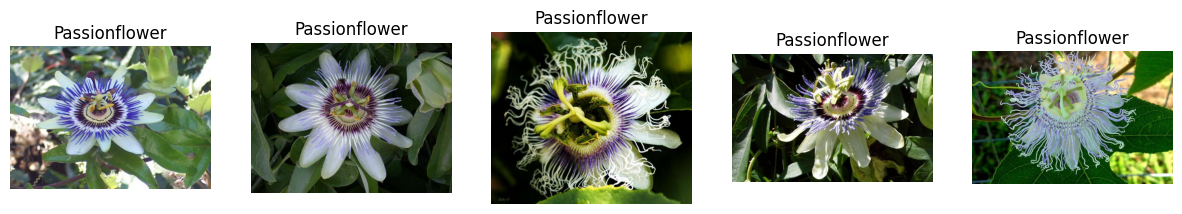

Displaying images for Class: Wallflower


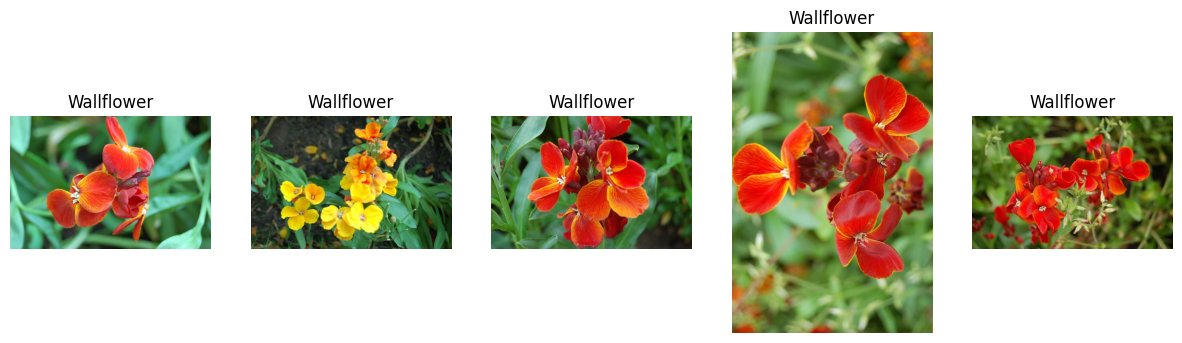

Displaying images for Class: Water Lily


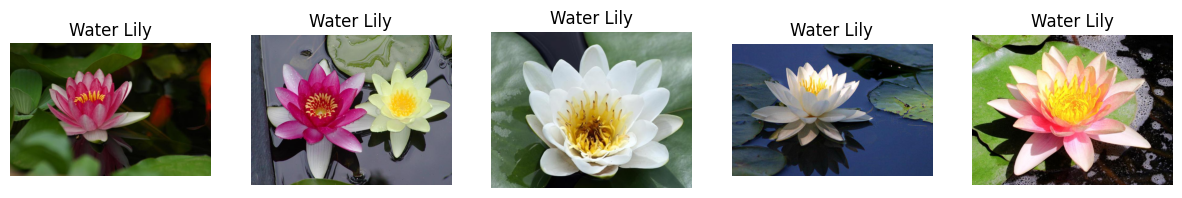

Displaying images for Class: Nasturtium


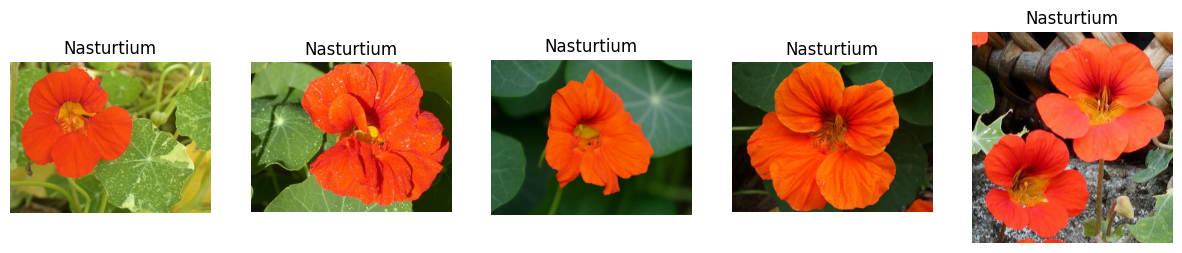

Displaying images for Class: Rose


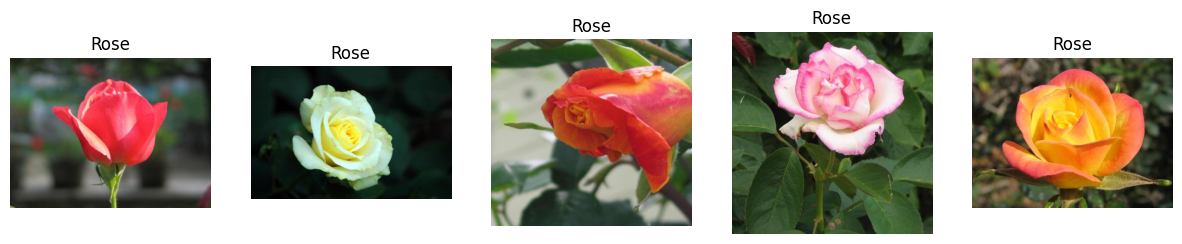

Displaying images for Class: Plumeria


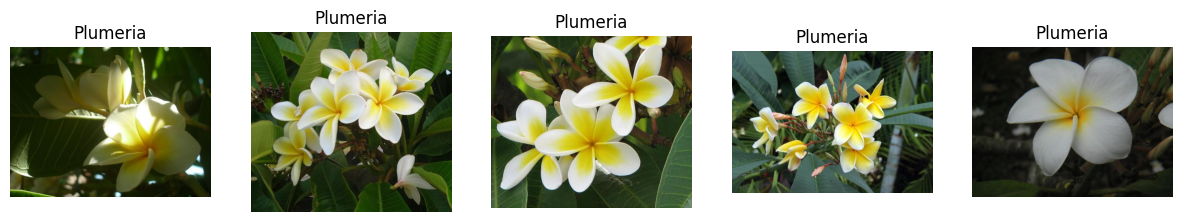

Displaying images for Class: Foxglove


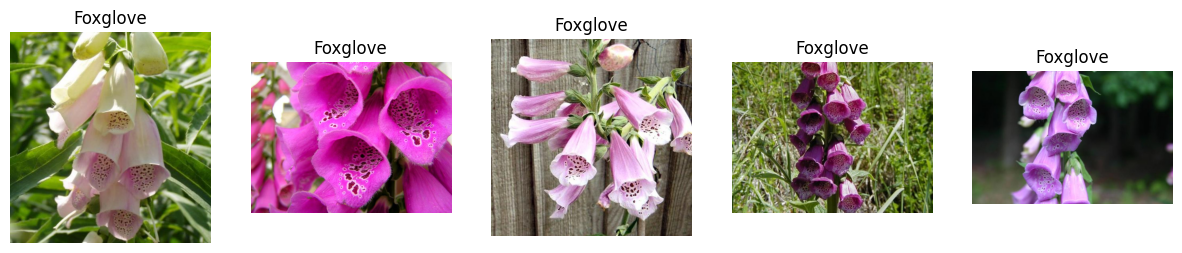

Displaying images for Class: Cyclamen


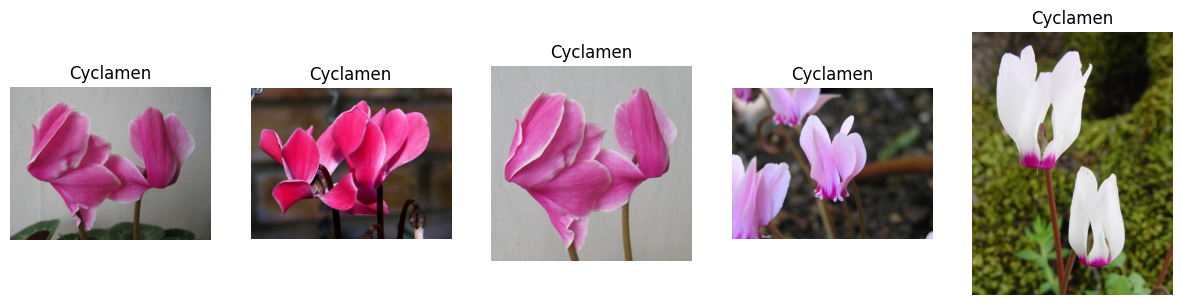

Displaying images for Class: Lotus


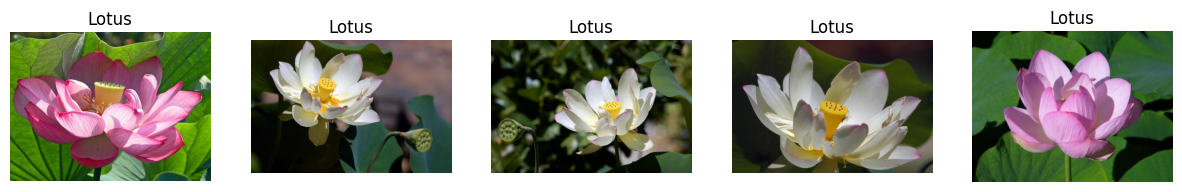

In [ ]:
# Path to the filtered dataset
filtered_image_folder_path = 'top_10_classes_dataset'

# Function to display images for a specific class
def display_images_for_class(class_name, num_images=5):
    # Get the folder corresponding to the class (by flower name)
    class_folder = os.path.join(filtered_image_folder_path, class_name)

    # Get all image paths in the class folder
    image_paths = glob.glob(os.path.join(class_folder, '*.jpg'))

    # Select a random subset of images to display
    selected_images = random.sample(image_paths, min(num_images, len(image_paths)))

    # Display images
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(selected_images):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)  # Use flower name as the title
    plt.show()

# Display 5 random images for each of the top 10 classes
for class_name in relabel_map.values():  # Iterate through flower names in relabel_map
    print(f"Displaying images for Class: {class_name}")
    display_images_for_class(class_name)

### 2. Data Preprocessing

In [ ]:

# Set image size and mean/std for normalization
image_size = 224
normalization_mean = [0.485, 0.456, 0.406]
normalization_std = [0.229, 0.224, 0.225]

# Define transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(normalization_mean, normalization_std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(normalization_mean, normalization_std)
])

# Load the dataset
dataset_path = 'top_10_classes_dataset'
dataset = ImageFolder(root=dataset_path)

# Split dataset into training (70%), validation (15%), and test (15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply transformations to the datasets
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Check the number of samples in each set
len(train_dataset), len(val_dataset), len(test_dataset)


(1311, 280, 282)

### 3. Model Selection and architecture

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the model architecture using ResNet18
class FlowerClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(FlowerClassifier, self).__init__()
        # Load the pre-trained ResNet18 model
        self.resnet = models.resnet18(pretrained=True)


        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the fully connected layer to match the number of classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),  # Add an intermediate fully connected layer
            nn.ReLU(),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(512, num_classes)  # Final layer for classification
        )

    def forward(self, x):
        return self.resnet(x)

# Instantiate the model
num_classes = 10
model = FlowerClassifier(num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Print model summary
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 95.6MB/s]


FlowerClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

###4. Model training

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, patience=2):
    best_val_loss = float("inf")
    early_stopping_counter = 0

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update metrics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Update metrics
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += torch.sum(preds == labels)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_correct.double() / val_total

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

        # Save metrics
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc.item())
        history["val_acc"].append(val_acc.item())

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved!")
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.04it/s]


Train Loss: 1.1446, Train Accuracy: 0.6560
Val Loss: 0.3308, Val Accuracy: 0.9464
Model saved!
Epoch 2/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.88it/s]


Train Loss: 0.2782, Train Accuracy: 0.9321
Val Loss: 0.1460, Val Accuracy: 0.9714
Model saved!
Epoch 3/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


Train Loss: 0.1767, Train Accuracy: 0.9512
Val Loss: 0.1238, Val Accuracy: 0.9714
Model saved!
Epoch 4/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.18it/s]


Train Loss: 0.1335, Train Accuracy: 0.9619
Val Loss: 0.0808, Val Accuracy: 0.9821
Model saved!
Epoch 5/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.62it/s]


Train Loss: 0.0763, Train Accuracy: 0.9863
Val Loss: 0.0625, Val Accuracy: 0.9821
Model saved!


### 5. Hyperparameter Tuning

In [ ]:
# Define hyperparameter grid
param_grid = {
    "learning_rate": [0.1, 0.01, 0.001],
    "batch_size": [16, 32, 64],
    "optimizer": ["SGD", "Adam"]
}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid["learning_rate"],
    param_grid["batch_size"],
    param_grid["optimizer"]
))

# Function to train and validate with specific hyperparameters
def train_with_params(lr, batch_size, optimizer_type):
    print(f"Training with lr={lr}, batch_size={batch_size}, optimizer={optimizer_type}")

    # Update DataLoader with new batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Define model, criterion, and optimizer
    model = FlowerClassifier(num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_type == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_type == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train the model
    history = train_model(model, train_loader, val_loader, criterion, optimizer)

    # Evaluate on validation set
    final_val_loss = history["val_loss"][-1]
    final_val_acc = history["val_acc"][-1]

    return final_val_loss, final_val_acc

# Hyperparameter tuning
results = []
for lr, batch_size, optimizer_type in param_combinations:
    val_loss, val_acc = train_with_params(lr, batch_size, optimizer_type)
    results.append((lr, batch_size, optimizer_type, val_loss, val_acc))

# Display results
results_df = pd.DataFrame(results, columns=["Learning Rate", "Batch Size", "Optimizer", "Val Loss", "Val Accuracy"])
results_df = results_df.sort_values(by="Val Accuracy", ascending=False)

# Save the results for analysis
results_df.to_csv("hyperparameter_tuning_results.csv", index=False)

# Display the best configuration
print("Best Hyperparameter Configuration:")
print(results_df.head(1))


Training with lr=0.1, batch_size=16, optimizer=SGD


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.89it/s]


Train Loss: 2.1833, Train Accuracy: 0.2960
Val Loss: 2.2154, Val Accuracy: 0.2000
Model saved!
Epoch 2/5


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.16it/s]


Train Loss: 2.2435, Train Accuracy: 0.1663
Val Loss: 2.1384, Val Accuracy: 0.1643
Model saved!
Epoch 3/5


Validation: 100%|██████████| 18/18 [00:02<00:00,  7.56it/s]


Train Loss: 2.2859, Train Accuracy: 0.1686
Val Loss: 2.2894, Val Accuracy: 0.1179
Epoch 4/5


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.70it/s]


Train Loss: 2.2921, Train Accuracy: 0.1510
Val Loss: 2.3022, Val Accuracy: 0.1107
Early stopping triggered!
Training with lr=0.1, batch_size=16, optimizer=Adam
Epoch 1/5


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.99it/s]


Train Loss: 23.5224, Train Accuracy: 0.2082
Val Loss: 2.3214, Val Accuracy: 0.1107
Model saved!
Epoch 2/5


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.04it/s]


Train Loss: 2.3882, Train Accuracy: 0.1434
Val Loss: 2.3127, Val Accuracy: 0.1143
Model saved!
Epoch 3/5


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.00it/s]


Train Loss: 2.3136, Train Accuracy: 0.1335
Val Loss: 2.3097, Val Accuracy: 0.1286
Model saved!
Epoch 4/5


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.87it/s]


Train Loss: 2.3168, Train Accuracy: 0.1281
Val Loss: 2.3356, Val Accuracy: 0.1107
Epoch 5/5


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.95it/s]


Train Loss: 2.3049, Train Accuracy: 0.1312
Val Loss: 2.3356, Val Accuracy: 0.1107
Early stopping triggered!
Training with lr=0.1, batch_size=32, optimizer=SGD
Epoch 1/5


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.24it/s]


Train Loss: 3.5171, Train Accuracy: 0.4050
Val Loss: 0.8028, Val Accuracy: 0.7607
Model saved!
Epoch 2/5


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.12it/s]


Train Loss: 1.4504, Train Accuracy: 0.5309
Val Loss: 1.1762, Val Accuracy: 0.6250
Epoch 3/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.05it/s]


Train Loss: 1.4713, Train Accuracy: 0.5164
Val Loss: 0.9248, Val Accuracy: 0.6929
Early stopping triggered!
Training with lr=0.1, batch_size=32, optimizer=Adam
Epoch 1/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


Train Loss: 96.5440, Train Accuracy: 0.1228
Val Loss: 2.2958, Val Accuracy: 0.1250
Model saved!
Epoch 2/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Train Loss: 2.4428, Train Accuracy: 0.1541
Val Loss: 2.3027, Val Accuracy: 0.1107
Epoch 3/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


Train Loss: 2.4086, Train Accuracy: 0.1518
Val Loss: 2.3042, Val Accuracy: 0.1107
Early stopping triggered!
Training with lr=0.1, batch_size=64, optimizer=SGD
Epoch 1/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Train Loss: 1.1987, Train Accuracy: 0.6354
Val Loss: 1.1421, Val Accuracy: 0.6821
Model saved!
Epoch 2/5


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Train Loss: 0.7714, Train Accuracy: 0.8421
Val Loss: 0.6975, Val Accuracy: 0.8536
Model saved!
Epoch 3/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Train Loss: 0.8540, Train Accuracy: 0.8322
Val Loss: 0.1650, Val Accuracy: 0.9571
Model saved!
Epoch 4/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Train Loss: 0.3693, Train Accuracy: 0.8863
Val Loss: 0.1568, Val Accuracy: 0.9429
Model saved!
Epoch 5/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Train Loss: 0.3545, Train Accuracy: 0.8894
Val Loss: 0.4825, Val Accuracy: 0.8750
Training with lr=0.1, batch_size=64, optimizer=Adam
Epoch 1/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Train Loss: 99.1721, Train Accuracy: 0.1869
Val Loss: 2.0807, Val Accuracy: 0.2214
Model saved!
Epoch 2/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Train Loss: 2.1059, Train Accuracy: 0.2349
Val Loss: 1.8286, Val Accuracy: 0.3393
Model saved!
Epoch 3/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


Train Loss: 2.0396, Train Accuracy: 0.2937
Val Loss: 1.5780, Val Accuracy: 0.4143
Model saved!
Epoch 4/5


Validation: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Train Loss: 1.8792, Train Accuracy: 0.3349
Val Loss: 1.5974, Val Accuracy: 0.3857
Epoch 5/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


Train Loss: 1.8791, Train Accuracy: 0.3349
Val Loss: 1.5587, Val Accuracy: 0.3857
Model saved!
Training with lr=0.01, batch_size=16, optimizer=SGD
Epoch 1/5


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.26it/s]


Train Loss: 1.0020, Train Accuracy: 0.6728
Val Loss: 0.1850, Val Accuracy: 0.9679
Model saved!
Epoch 2/5


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.97it/s]


Train Loss: 0.2554, Train Accuracy: 0.9214
Val Loss: 0.1306, Val Accuracy: 0.9464
Model saved!
Epoch 3/5


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.80it/s]


Train Loss: 0.2207, Train Accuracy: 0.9260
Val Loss: 0.0830, Val Accuracy: 0.9643
Model saved!
Epoch 4/5


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.94it/s]


Train Loss: 0.1901, Train Accuracy: 0.9344
Val Loss: 0.0898, Val Accuracy: 0.9643
Epoch 5/5


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.82it/s]


Train Loss: 0.1474, Train Accuracy: 0.9550
Val Loss: 0.0811, Val Accuracy: 0.9714
Model saved!
Training with lr=0.01, batch_size=16, optimizer=Adam
Epoch 1/5


Validation: 100%|██████████| 18/18 [00:02<00:00,  8.72it/s]


Train Loss: 1.4887, Train Accuracy: 0.6377
Val Loss: 0.1925, Val Accuracy: 0.9464
Model saved!
Epoch 2/5


Validation: 100%|██████████| 18/18 [00:02<00:00,  7.33it/s]


Train Loss: 0.5804, Train Accuracy: 0.8047
Val Loss: 0.2273, Val Accuracy: 0.9357
Epoch 3/5


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.90it/s]


Train Loss: 0.5656, Train Accuracy: 0.8040
Val Loss: 0.2607, Val Accuracy: 0.9214
Early stopping triggered!
Training with lr=0.01, batch_size=32, optimizer=SGD
Epoch 1/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s]


Train Loss: 1.2885, Train Accuracy: 0.6049
Val Loss: 0.3216, Val Accuracy: 0.9321
Model saved!
Epoch 2/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.11it/s]


Train Loss: 0.2799, Train Accuracy: 0.9207
Val Loss: 0.1251, Val Accuracy: 0.9750
Model saved!
Epoch 3/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Train Loss: 0.2163, Train Accuracy: 0.9352
Val Loss: 0.0921, Val Accuracy: 0.9821
Model saved!
Epoch 4/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.08it/s]


Train Loss: 0.0950, Train Accuracy: 0.9794
Val Loss: 0.0915, Val Accuracy: 0.9786
Model saved!
Epoch 5/5


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.19it/s]


Train Loss: 0.1070, Train Accuracy: 0.9687
Val Loss: 0.0951, Val Accuracy: 0.9714
Training with lr=0.01, batch_size=32, optimizer=Adam
Epoch 1/5


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.00it/s]


Train Loss: 2.4493, Train Accuracy: 0.4821
Val Loss: 0.3983, Val Accuracy: 0.9071
Model saved!
Epoch 2/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


Train Loss: 0.4870, Train Accuracy: 0.8330
Val Loss: 0.1445, Val Accuracy: 0.9607
Model saved!
Epoch 3/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.07it/s]


Train Loss: 0.2857, Train Accuracy: 0.9108
Val Loss: 0.0866, Val Accuracy: 0.9821
Model saved!
Epoch 4/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.08it/s]


Train Loss: 0.2783, Train Accuracy: 0.9092
Val Loss: 0.1127, Val Accuracy: 0.9536
Epoch 5/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


Train Loss: 0.2633, Train Accuracy: 0.9169
Val Loss: 0.0992, Val Accuracy: 0.9571
Early stopping triggered!
Training with lr=0.01, batch_size=64, optimizer=SGD
Epoch 1/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Train Loss: 1.7374, Train Accuracy: 0.5164
Val Loss: 0.8838, Val Accuracy: 0.8536
Model saved!
Epoch 2/5


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Train Loss: 0.5633, Train Accuracy: 0.8726
Val Loss: 0.2458, Val Accuracy: 0.9286
Model saved!
Epoch 3/5


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Train Loss: 0.2341, Train Accuracy: 0.9451
Val Loss: 0.1732, Val Accuracy: 0.9643
Model saved!
Epoch 4/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Train Loss: 0.1695, Train Accuracy: 0.9588
Val Loss: 0.1072, Val Accuracy: 0.9786
Model saved!
Epoch 5/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Train Loss: 0.1155, Train Accuracy: 0.9733
Val Loss: 0.0802, Val Accuracy: 0.9786
Model saved!
Training with lr=0.01, batch_size=64, optimizer=Adam
Epoch 1/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Train Loss: 3.2528, Train Accuracy: 0.4050
Val Loss: 0.6416, Val Accuracy: 0.8214
Model saved!
Epoch 2/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Train Loss: 0.4652, Train Accuracy: 0.8551
Val Loss: 0.1996, Val Accuracy: 0.9393
Model saved!
Epoch 3/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


Train Loss: 0.2142, Train Accuracy: 0.9336
Val Loss: 0.0863, Val Accuracy: 0.9821
Model saved!
Epoch 4/5


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Train Loss: 0.1606, Train Accuracy: 0.9519
Val Loss: 0.0886, Val Accuracy: 0.9643
Epoch 5/5


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Train Loss: 0.1239, Train Accuracy: 0.9573
Val Loss: 0.1083, Val Accuracy: 0.9714
Early stopping triggered!
Training with lr=0.001, batch_size=16, optimizer=SGD
Epoch 1/5


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.01it/s]


Train Loss: 1.9533, Train Accuracy: 0.4035
Val Loss: 1.4259, Val Accuracy: 0.7857
Model saved!
Epoch 2/5


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.13it/s]


Train Loss: 1.1690, Train Accuracy: 0.7567
Val Loss: 0.7620, Val Accuracy: 0.9143
Model saved!
Epoch 3/5


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.06it/s]


Train Loss: 0.6858, Train Accuracy: 0.8810
Val Loss: 0.4256, Val Accuracy: 0.9714
Model saved!
Epoch 4/5


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.09it/s]


Train Loss: 0.4948, Train Accuracy: 0.8993
Val Loss: 0.2954, Val Accuracy: 0.9857
Model saved!
Epoch 5/5


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.13it/s]


Train Loss: 0.3603, Train Accuracy: 0.9321
Val Loss: 0.2418, Val Accuracy: 0.9643
Model saved!
Training with lr=0.001, batch_size=16, optimizer=Adam
Epoch 1/5


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.96it/s]


Train Loss: 1.0330, Train Accuracy: 0.6728
Val Loss: 0.3339, Val Accuracy: 0.8964
Model saved!
Epoch 2/5


Validation: 100%|██████████| 18/18 [00:02<00:00,  7.20it/s]


Train Loss: 0.3113, Train Accuracy: 0.9100
Val Loss: 0.1127, Val Accuracy: 0.9679
Model saved!
Epoch 3/5


Validation: 100%|██████████| 18/18 [00:01<00:00,  9.09it/s]


Train Loss: 0.1999, Train Accuracy: 0.9458
Val Loss: 0.1775, Val Accuracy: 0.9286
Epoch 4/5


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.13it/s]


Train Loss: 0.1406, Train Accuracy: 0.9603
Val Loss: 0.0760, Val Accuracy: 0.9786
Model saved!
Epoch 5/5


Validation: 100%|██████████| 18/18 [00:01<00:00, 10.00it/s]


Train Loss: 0.0941, Train Accuracy: 0.9756
Val Loss: 0.0788, Val Accuracy: 0.9714
Training with lr=0.001, batch_size=32, optimizer=SGD
Epoch 1/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.24it/s]


Train Loss: 2.1887, Train Accuracy: 0.2296
Val Loss: 1.9001, Val Accuracy: 0.5036
Model saved!
Epoch 2/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.21it/s]


Train Loss: 1.6875, Train Accuracy: 0.6163
Val Loss: 1.4050, Val Accuracy: 0.7321
Model saved!
Epoch 3/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  4.85it/s]


Train Loss: 1.2343, Train Accuracy: 0.7857
Val Loss: 0.9703, Val Accuracy: 0.8964
Model saved!
Epoch 4/5


Validation: 100%|██████████| 9/9 [00:02<00:00,  3.64it/s]


Train Loss: 0.9099, Train Accuracy: 0.8528
Val Loss: 0.7032, Val Accuracy: 0.9321
Model saved!
Epoch 5/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.08it/s]


Train Loss: 0.6874, Train Accuracy: 0.8932
Val Loss: 0.5363, Val Accuracy: 0.9607
Model saved!
Training with lr=0.001, batch_size=32, optimizer=Adam
Epoch 1/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.13it/s]


Train Loss: 1.0385, Train Accuracy: 0.7109
Val Loss: 0.2846, Val Accuracy: 0.9464
Model saved!
Epoch 2/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.22it/s]


Train Loss: 0.2536, Train Accuracy: 0.9359
Val Loss: 0.1826, Val Accuracy: 0.9500
Model saved!
Epoch 3/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.16it/s]


Train Loss: 0.1564, Train Accuracy: 0.9634
Val Loss: 0.0919, Val Accuracy: 0.9750
Model saved!
Epoch 4/5


Validation: 100%|██████████| 9/9 [00:01<00:00,  5.19it/s]


Train Loss: 0.1118, Train Accuracy: 0.9718
Val Loss: 0.0827, Val Accuracy: 0.9750
Model saved!
Epoch 5/5


Validation: 100%|██████████| 9/9 [00:02<00:00,  4.04it/s]


Train Loss: 0.0994, Train Accuracy: 0.9771
Val Loss: 0.0645, Val Accuracy: 0.9786
Model saved!
Training with lr=0.001, batch_size=64, optimizer=SGD
Epoch 1/5


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


Train Loss: 2.2647, Train Accuracy: 0.1465
Val Loss: 2.1273, Val Accuracy: 0.2393
Model saved!
Epoch 2/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Train Loss: 1.9897, Train Accuracy: 0.3997
Val Loss: 1.8432, Val Accuracy: 0.6214
Model saved!
Epoch 3/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Train Loss: 1.7220, Train Accuracy: 0.6476
Val Loss: 1.5746, Val Accuracy: 0.7143
Model saved!
Epoch 4/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Train Loss: 1.4520, Train Accuracy: 0.7437
Val Loss: 1.3134, Val Accuracy: 0.8357
Model saved!
Epoch 5/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


Train Loss: 1.2234, Train Accuracy: 0.8070
Val Loss: 1.0964, Val Accuracy: 0.8929
Model saved!
Training with lr=0.001, batch_size=64, optimizer=Adam
Epoch 1/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Train Loss: 1.3538, Train Accuracy: 0.6087
Val Loss: 0.4686, Val Accuracy: 0.9357
Model saved!
Epoch 2/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Train Loss: 0.3515, Train Accuracy: 0.9252
Val Loss: 0.1708, Val Accuracy: 0.9821
Model saved!
Epoch 3/5


Validation: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


Train Loss: 0.1709, Train Accuracy: 0.9603
Val Loss: 0.1267, Val Accuracy: 0.9786
Model saved!
Epoch 4/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Train Loss: 0.1293, Train Accuracy: 0.9680
Val Loss: 0.1277, Val Accuracy: 0.9750
Epoch 5/5


Validation: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Train Loss: 0.1041, Train Accuracy: 0.9794
Val Loss: 0.0866, Val Accuracy: 0.9714
Model saved!
Best Hyperparameter Configuration:
    Learning Rate  Batch Size Optimizer  Val Loss  Val Accuracy
10           0.01          64       SGD  0.080243      0.978571


### 6. Evaluation

Validation Loss: 0.06245639872338091
Classification Report:
                precision    recall  f1-score   support

     Cyclamen       1.00      0.96      0.98        28
     Foxglove       1.00      0.95      0.98        22
        Lotus       1.00      1.00      1.00        18
   Nasturtium       0.97      1.00      0.98        30
Passionflower       0.97      1.00      0.99        36
      Petunia       0.97      0.94      0.95        31
     Plumeria       1.00      1.00      1.00        21
         Rose       0.92      1.00      0.96        22
   Wallflower       1.00      1.00      1.00        33
   Water Lily       1.00      0.97      0.99        39

     accuracy                           0.98       280
    macro avg       0.98      0.98      0.98       280
 weighted avg       0.98      0.98      0.98       280



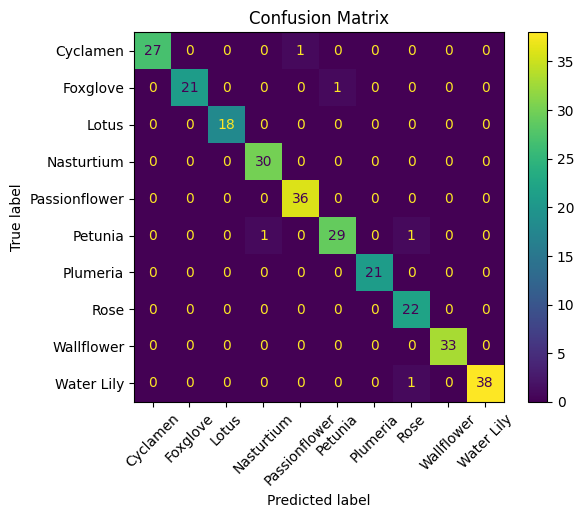

In [ ]:
# Function to evaluate the model on a given DataLoader
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss, np.array(all_preds), np.array(all_labels)

# Evaluate on validation set
val_loss, val_preds, val_labels = evaluate_model(model, val_loader, criterion)

# Classification report
print("Validation Loss:", val_loss)
print("Classification Report:\n", classification_report(val_labels, val_preds, target_names=dataset.classes))

# Confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


Visualizing predictions...


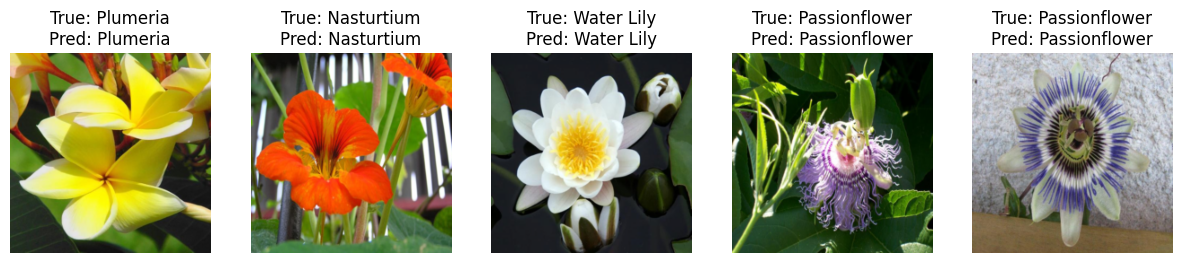

In [ ]:
# Function to visualize predictions
def visualize_predictions(data_loader, model, num_images=5):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    plt.show()
                    return

                img = inputs[i].cpu().permute(1, 2, 0).numpy()
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
                img = np.clip(img, 0, 1)

                plt.subplot(1, num_images, images_shown + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"True: {dataset.classes[labels[i].item()]}\nPred: {dataset.classes[preds[i].item()]}")
                images_shown += 1

# Visualize predictions
print("Visualizing predictions...")
visualize_predictions(val_loader, model, num_images=5)
